# ANALYSIS OF HURRICANE TRACKS AND DEMOGRAPHICS TO ALLOCATE THE RELIEF RESOURCES
------------------------------------------------------------------------------------------------------------------------------
Project developed by Anuradha Tidke, Rehapriadarsini Manikandasamy, Venkata Gangadhar Naveen Palaka


## Problem Statement

Hurricanes cause billions of dollars in damage annually in the United States. Exploring historical patterns of hurricanes and exposure of these hurricane-force winds across the landscape, areas of potentially high threat to future hurricane winds can be revealed.

The objective of the project is to develop an overall analysis of the areas affected by hurricanes across the US. The goal of the work is to track the path of some major hurricanes of 2020 and 2021 and find the states which have been most commonly affected. Using their intersection on census tract and health center data, the location of health centers are tracked based on the demographic information available.


Reference: Jason Cole, David J Nowak, Eric J Greenfield, Potential Hurricane Wind Risk to US Rural and Urban Forests, Journal of Forestry, Volume 119, Issue 4, July 2021, Pages 393–406, https://doi.org/10.1093/jofore/fvab018

## Solution proposed
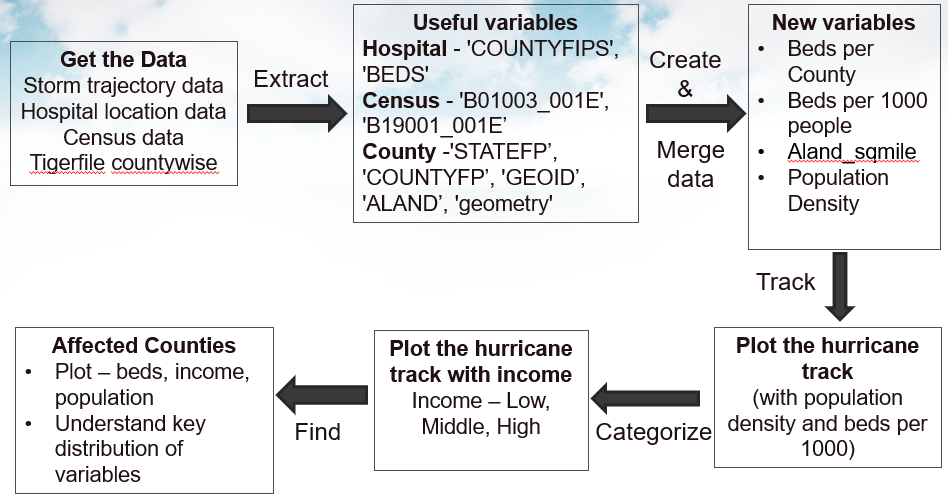

## Solution Code

## Step 1: Download and Process Hospital data

Download the hospitals location data from: 

https://hifld-geoplatform.opendata.arcgis.com/datasets/geoplatform::hospitals-1/explore?location=36.455537%2C-114.575752%2C3.60. 

After opening this link, follow the download link as follows:
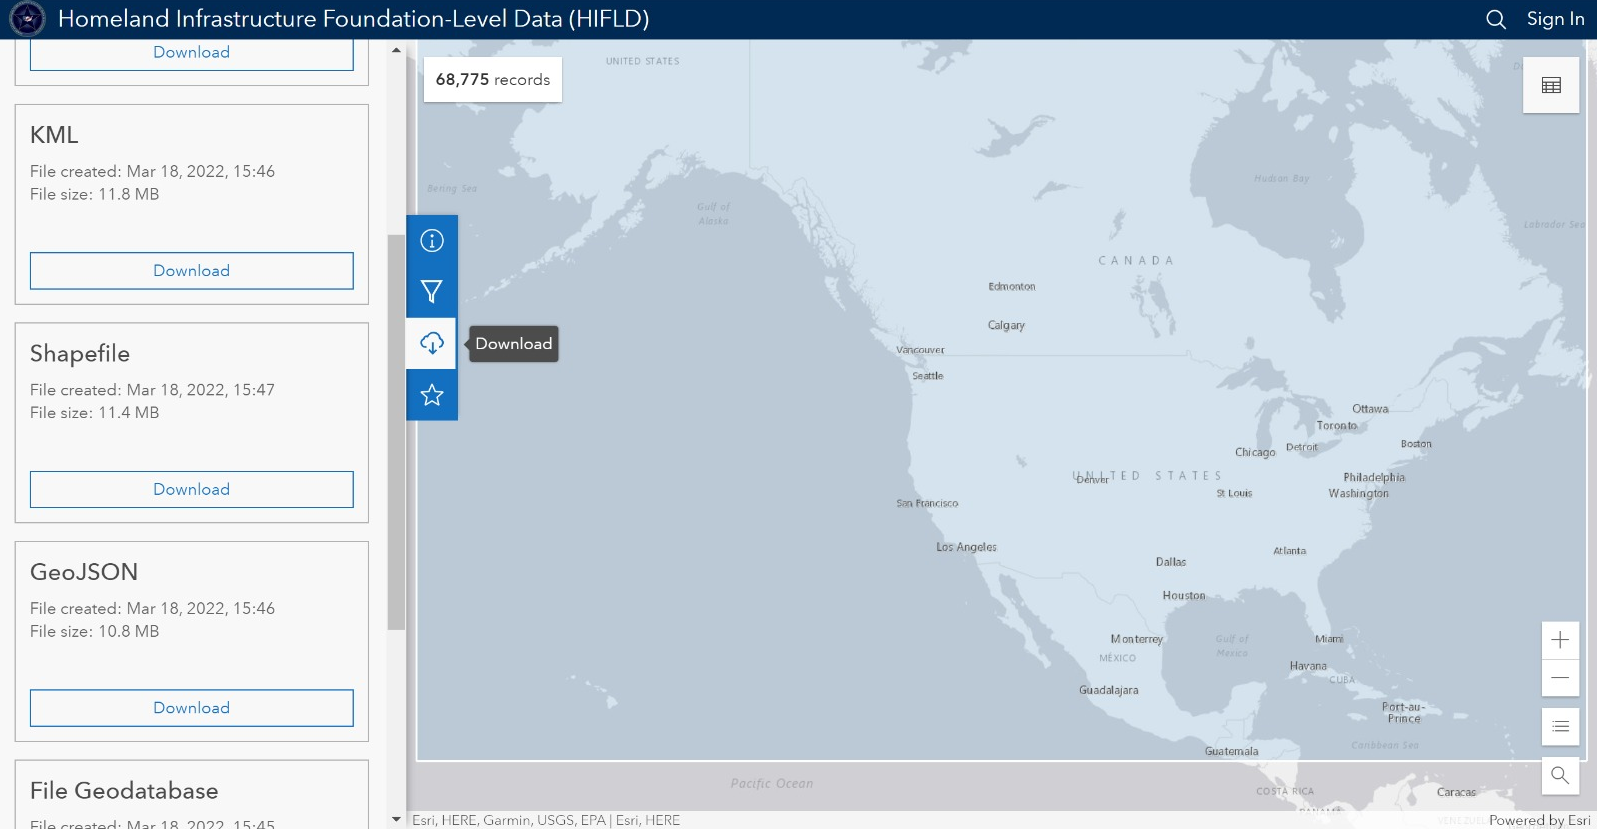

In [1]:
#Load the dataset
import geopandas as gpd
hosp_data = gpd.read_file('Hospitals.geojson')

In [2]:
#Print the columns of the dataset
hosp_data.columns

Index(['OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'ZIP4',
       'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY', 'COUNTYFIPS',
       'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'STATE_ID',
       'ALT_NAME', 'ST_FIPS', 'OWNER', 'TTL_STAFF', 'BEDS', 'TRAUMA',
       'HELIPAD', 'GlobalID', 'geometry'],
      dtype='object')

### Extracting and grouping useful variables

Since, the project is mainly focussed on analysis of bed availability in the county let's extract only the county and bed information from the dataset.

In [3]:
#Copy the dataset with only two columns to a new variable
hosp_loc_data = hosp_data[['COUNTYFIPS', 'BEDS']].copy()

In [4]:
hosp_loc_data.head()

,COUNTYFIPS,BEDS
0,06031,49.0
1,06111,40.0
2,06037,127.0
3,06037,100.0
4,06037,95.0


In [5]:
#Group the data based on 'COUNTYFIPS' column and find the sum of beds in each county
hosp_total_beds_countywise = hosp_loc_data[['COUNTYFIPS', 'BEDS']].copy()
hosp_total_beds_countywise = hosp_total_beds_countywise.groupby(['COUNTYFIPS']).sum()
hosp_total_beds_countywise = hosp_total_beds_countywise.reset_index()

hosp_total_beds_countywise = hosp_total_beds_countywise[(hosp_total_beds_countywise[['BEDS']] > 0).all(1)]

hosp_total_beds_countywise.head()

,COUNTYFIPS,BEDS
0,01001,765.0
1,01003,3582.0
2,01005,666.0
3,01007,315.0
4,01009,360.0


## Step 2: Download and Process Census data

This data will help in understanding the total population and income of a household.


Variable Definition:

B01003_001E - TOTAL POPULATION

B19001_001E - HOUSEHOLD INCOME IN PAST 12 MONTHS

In [6]:
# ! pip install censusdata

In [7]:
from census import Census
from us import states
import censusdata
import pandas as pd

#import the census data and download the respective census variables
pop_var = ['B01003_001E', 'B19001_001E']

pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 2)

county_details = censusdata.download('acs5', 2020, censusdata.censusgeo([('county', '*')]),
                                   pop_var)

In [8]:
county_details = county_details.reset_index()

In [9]:
county_details.head()

,index,B01003_001E,B19001_001E
0,"Autauga County, Alabama: Summary level: 050, s...",55639,21559
1,"Baldwin County, Alabama: Summary level: 050, s...",218289,84047
2,"Barbour County, Alabama: Summary level: 050, s...",25026,9322
3,"Bibb County, Alabama: Summary level: 050, stat...",22374,7259
4,"Blount County, Alabama: Summary level: 050, st...",57755,21205


### Extracting county and state information

Looking at the above dataframe, we can see the county and other demographic information are available in single column which makes our analysis difficult. Hence, we need to create new variables like stateName, countyName. The dataset needs 'COUNTYFIPS' column inorder to be merged with hospital dataset, so a new variable 'COUNTYFIPS' is created by joining the state and county ID.

In [10]:
states_ID = []
counties_ID = []
states_name = []
counties_name = []
for det in county_details['index']:
    state_ID = det.geo[0][1]
    states_ID.append(state_ID)
    county_ID = det.geo[1][1]
    counties_ID.append(county_ID)
    state_name = det.name.split(', ')[1]
    states_name.append(state_name)
    county_name = det.name.split(', ')[0]
    counties_name.append(county_name)

### Renaming census variables

B01003_001E - TotalPop

B19001_001E - Income

In [11]:
#Crreate COUNTYFIPS variable and rename the census varaibles

county_details['state'] = states_ID
county_details['county'] = counties_ID
county_details['stateName'] = states_name
county_details['countyName'] = counties_name
county_details['COUNTYFIPS'] = county_details['state'] + county_details['county']
county_details = county_details.drop(columns = ['index','county', 'state'])
county_details = county_details.rename(columns={'B01003_001E': 'TotalPop', 'B19001_001E': 'Income'})

In [12]:
county_details.head()

,TotalPop,Income,stateName,countyName,COUNTYFIPS
0,55639,21559,Alabama,Autauga County,01001
1,218289,84047,Alabama,Baldwin County,01003
2,25026,9322,Alabama,Barbour County,01005
3,22374,7259,Alabama,Bibb County,01007
4,57755,21205,Alabama,Blount County,01009


## Step 3: Merging the hospital and census data, and creating useful variables (Bed_per_1000)

The new variable is created to calculate number of beds available per 1000 individuals in a county. This will help in future analysis for the health officials to understand whether a county will be in need of more beds to accomodate the people based on the county.

For example, consider there are 400 beds available for two counties with different population. A county population of 10000 would be having less number of beds per 1000 people while county of population 1000 will have sufficient number of beds.

In [13]:
#Create new variable Beds_per_1000 
hosp_census_join = county_details.merge(right=hosp_total_beds_countywise, how='right',on='COUNTYFIPS', validate='one_to_one')

hosp_census_join['Bed_per_1000'] = (hosp_census_join['BEDS'] * 1000 / hosp_census_join['TotalPop']).round(decimals = 0)

In [14]:
hosp_census_join = hosp_census_join.drop(columns=['BEDS'])

In [15]:
hosp_census_join.head()

,TotalPop,Income,stateName,countyName,COUNTYFIPS,Bed_per_1000
0,55639.0,21559.0,Alabama,Autauga County,01001,14.0
1,218289.0,84047.0,Alabama,Baldwin County,01003,16.0
2,25026.0,9322.0,Alabama,Barbour County,01005,27.0
3,22374.0,7259.0,Alabama,Bibb County,01007,14.0
4,57755.0,21205.0,Alabama,Blount County,01009,6.0


## Step 4: Download and Process Tiger file countywise

In [ ]:
! wget https://www2.census.gov/geo/tiger/TIGER2021/COUNTY/tl_2021_us_county.zip

In [ ]:
! mkdir tl_2021_us_county
import zipfile
with zipfile.ZipFile('tl_2021_us_county.zip','r') as zip_ref:
    zip_ref.extractall('tl_2021_us_county')

In [18]:
county_shp = gpd.read_file('./tl_2021_us_county/tl_2021_us_county.shp')
county_shp.head(2)

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477645345,10690204,+41.9158651,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680976231,61568965,+46.2946377,-123.4244583,"POLYGON ((-123.49077 46.38358, -123.48813 46.3..."


### Extracting useful variables and creating new variables (ALAND_SqMile)

In [19]:
#Extract the useful variables
county_shp_new = county_shp[['STATEFP','COUNTYFP','GEOID','ALAND','geometry']].copy()

In [20]:
county_shp_new['COUNTYFIPS'] = county_shp_new['STATEFP'] + county_shp_new['COUNTYFP']

# Converting land area variable from square kilometers to square miles because the population density in the US is measured as people per square mile.
county_shp_new['ALAND_SqMile'] = county_shp_new['ALAND']*3.861e-7
county_shp_new = county_shp_new.drop(columns=['STATEFP','COUNTYFP', 'ALAND'])
county_shp_new = county_shp_new.sort_values(by=['COUNTYFIPS'])

In [21]:
county_shp_new.head()

,GEOID,geometry,COUNTYFIPS,ALAND_SqMile
1327,01001,"POLYGON ((-86.58826 32.36775, -86.58834 32.367...",01001,594.45
1246,01003,"POLYGON ((-87.61542 31.04100, -87.61542 31.040...",01003,1589.83
1826,01005,"POLYGON ((-85.41585 31.68164, -85.41619 31.677...",01005,885.00
3015,01007,"POLYGON ((-86.87657 33.01891, -86.87657 33.018...",01007,622.47
855,01009,"POLYGON ((-86.56421 33.80194, -86.56556 33.801...",01009,644.89


## Step 5: Merging hospital and census data with county shape data

### Cleaning the dataframe and creating new variable (PopDen)

The new varaible 'PopDen' is created to understand whether a county is densely populated or not.

In [22]:
hosp_census_countySHP_join = county_shp_new.merge(right= hosp_census_join, how='right',on='COUNTYFIPS', validate='one_to_one')

hosp_census_countySHP_join = hosp_census_countySHP_join.dropna()

hosp_census_countySHP_join['PopDen'] = hosp_census_countySHP_join['TotalPop'] / hosp_census_countySHP_join['ALAND_SqMile']

hosp_census_countySHP_join = hosp_census_countySHP_join[hosp_census_countySHP_join['stateName'].isin(['Alaska','Hawaii','Puerto Rico']) == False]

hosp_census_countySHP_join = hosp_census_countySHP_join.drop(columns = ['GEOID', 'COUNTYFIPS', 'ALAND_SqMile', 'TotalPop'])
hosp_census_countySHP_join.head()

,geometry,Income,stateName,countyName,Bed_per_1000,PopDen
0,"POLYGON ((-86.58826 32.36775, -86.58834 32.367...",21559.0,Alabama,Autauga County,14.0,93.60
1,"POLYGON ((-87.61542 31.04100, -87.61542 31.040...",84047.0,Alabama,Baldwin County,16.0,137.30
2,"POLYGON ((-85.41585 31.68164, -85.41619 31.677...",9322.0,Alabama,Barbour County,27.0,28.28
3,"POLYGON ((-86.87657 33.01891, -86.87657 33.018...",7259.0,Alabama,Bibb County,14.0,35.94
4,"POLYGON ((-86.56421 33.80194, -86.56556 33.801...",21205.0,Alabama,Blount County,6.0,89.56


## Step 6: Download hurricane track data for hurricanes Ida (2021) and Laura (2020) 

The two hurricanes are chosen since they are the most strongest hurricanes of their respective years. And most of the hurricanes which are formed don't make up till the land surface. Hence, the analysis will be only focussing on hurricanes which affected the land areas.

In [ ]:
# Hurricane Ida
! wget https://www.nhc.noaa.gov/gis/forecast/archive/al092021_5day_001.zip
! mkdir al092021_5day_001
with zipfile.ZipFile('al092021_5day_001.zip','r') as zip_ref:
    zip_ref.extractall('al092021_5day_001')

In [ ]:
# Hurricane Laura
! wget https://www.nhc.noaa.gov/gis/forecast/archive/al132020_5day_010.zip
! mkdir al132020_5day_010
with zipfile.ZipFile('al132020_5day_010.zip','r') as zip_ref:
    zip_ref.extractall('al132020_5day_010')

In [25]:
#Load data of hurricane Ida and drop unwanted variables
ida = gpd.read_file('./al092021_5day_001/al092021-001_5day_pgn.shp')
ida.crs = "EPSG:4269"
ida = ida.drop(columns = ['STORMTYPE', 'ADVDATE', 'ADVISNUM', 'STORMNUM', 'FCSTPRD', 'BASIN'])

In [26]:
#Load data of hurricane Ida and drop unwanted variables
laura = gpd.read_file('./al132020_5day_010/al132020-010_5day_pgn.shp')
laura.crs = "EPSG:4269"
laura = laura.drop(columns = ['STORMTYPE', 'ADVDATE', 'ADVISNUM', 'STORMNUM', 'FCSTPRD', 'BASIN'])

## Step 7: Useful Plots

### Plotting "Population density" with hurricane tracks

This helps us to find whether the hurricane has affected highly populated area or not.

***The value limits to plot the following graph were taken from a similar visualization on:***

https://www.census.gov/library/visualizations/2010/geo/population-density-county-2010.html

Text(0.5, 1.0, 'Population Density for all the US counties')

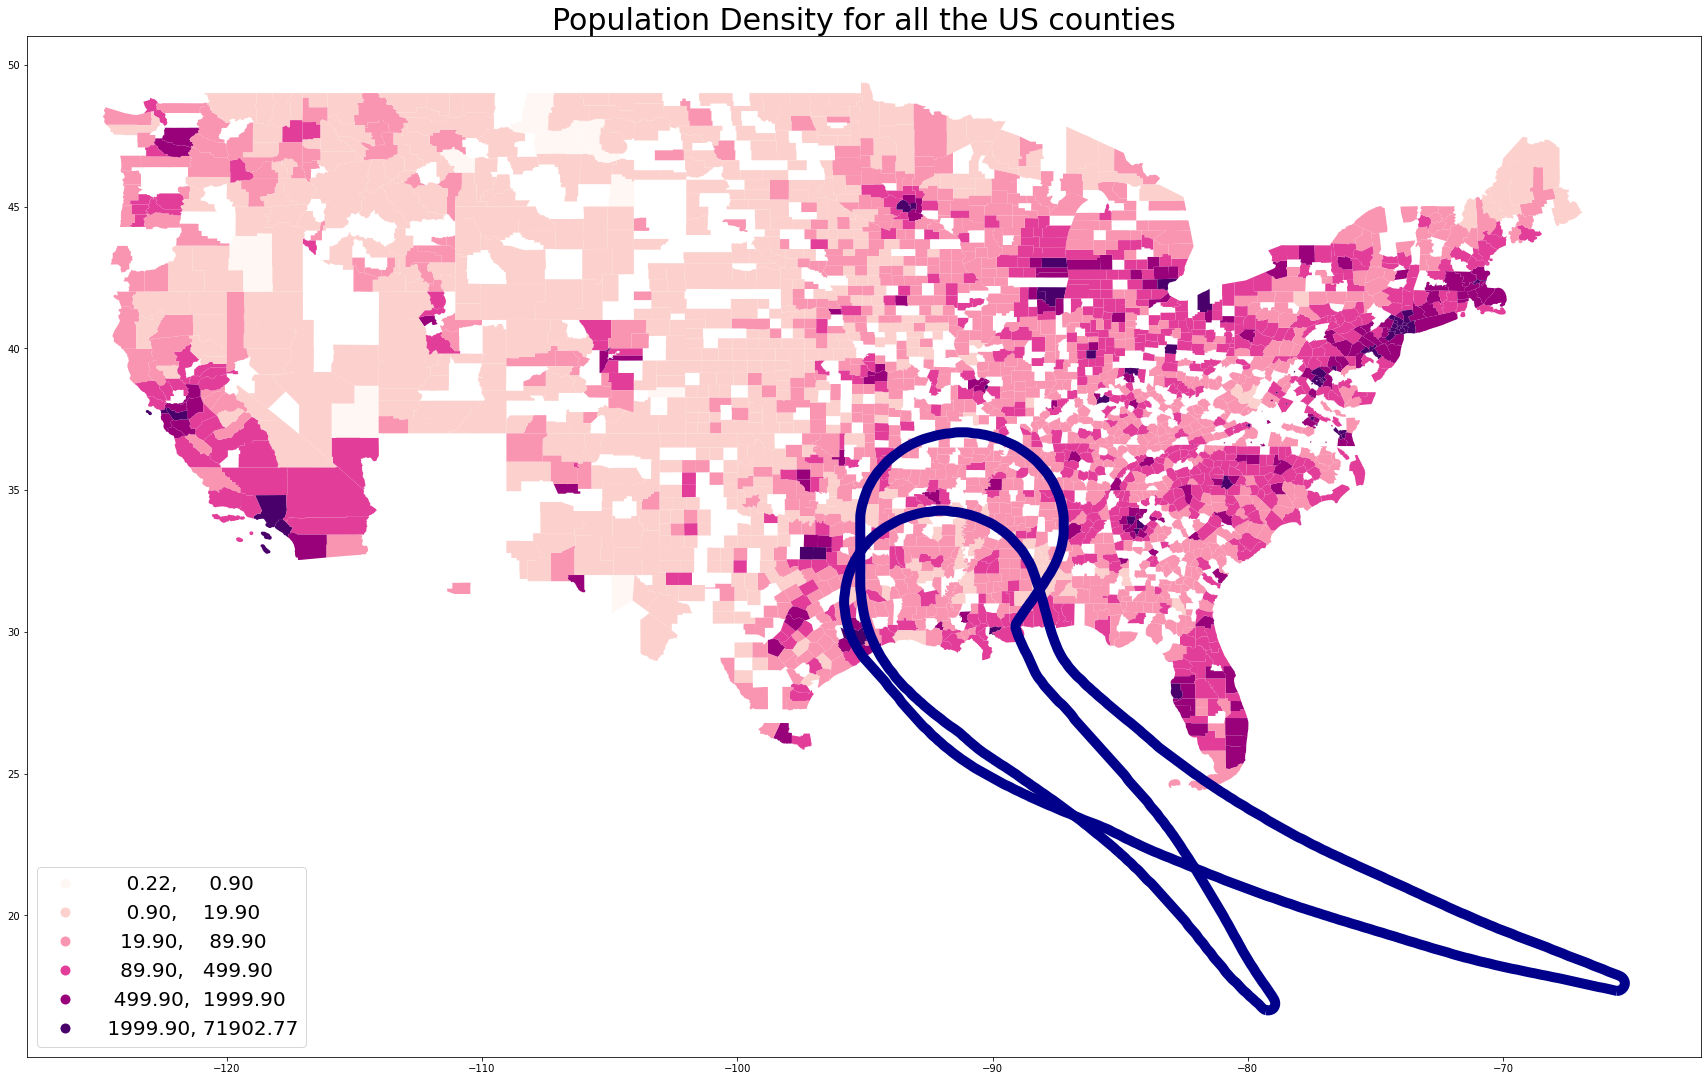

In [62]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, figsize=(30,20))

max_popDen = hosp_census_countySHP_join['PopDen'].max()
base = hosp_census_countySHP_join.plot(ax=ax, column = 'PopDen', cmap = 'RdPu', scheme = "UserDefined",
                                       classification_kwds=dict(bins=[0.9,19.9,89.9,499.9,1999.9,max_popDen]),legend = True,
                                      legend_kwds={'loc': 'lower left', 'fontsize': 20})

# plotting the hurricane position on top with red color to stand out:
ida.boundary.plot(ax=base, color = 'darkblue', linewidth=10)
laura.boundary.plot(ax=base, color = 'darkblue', linewidth=10)
plt.title(label = "Population Density for all the US counties", fontsize = 30)

### Plotting "Bed per 1000" people with hurricane tracks


This analysis will help understanding whether there are required amount of beds in a county or not.

***The value limits to plot the following graph were taken from a similar visualization on:***

https://www.covidcaremap.org/maps/us-healthcare-system-capacity/#3.5/38/-96

Text(0.5, 1.0, 'Number of available beds per 1000 people for all the US counties')

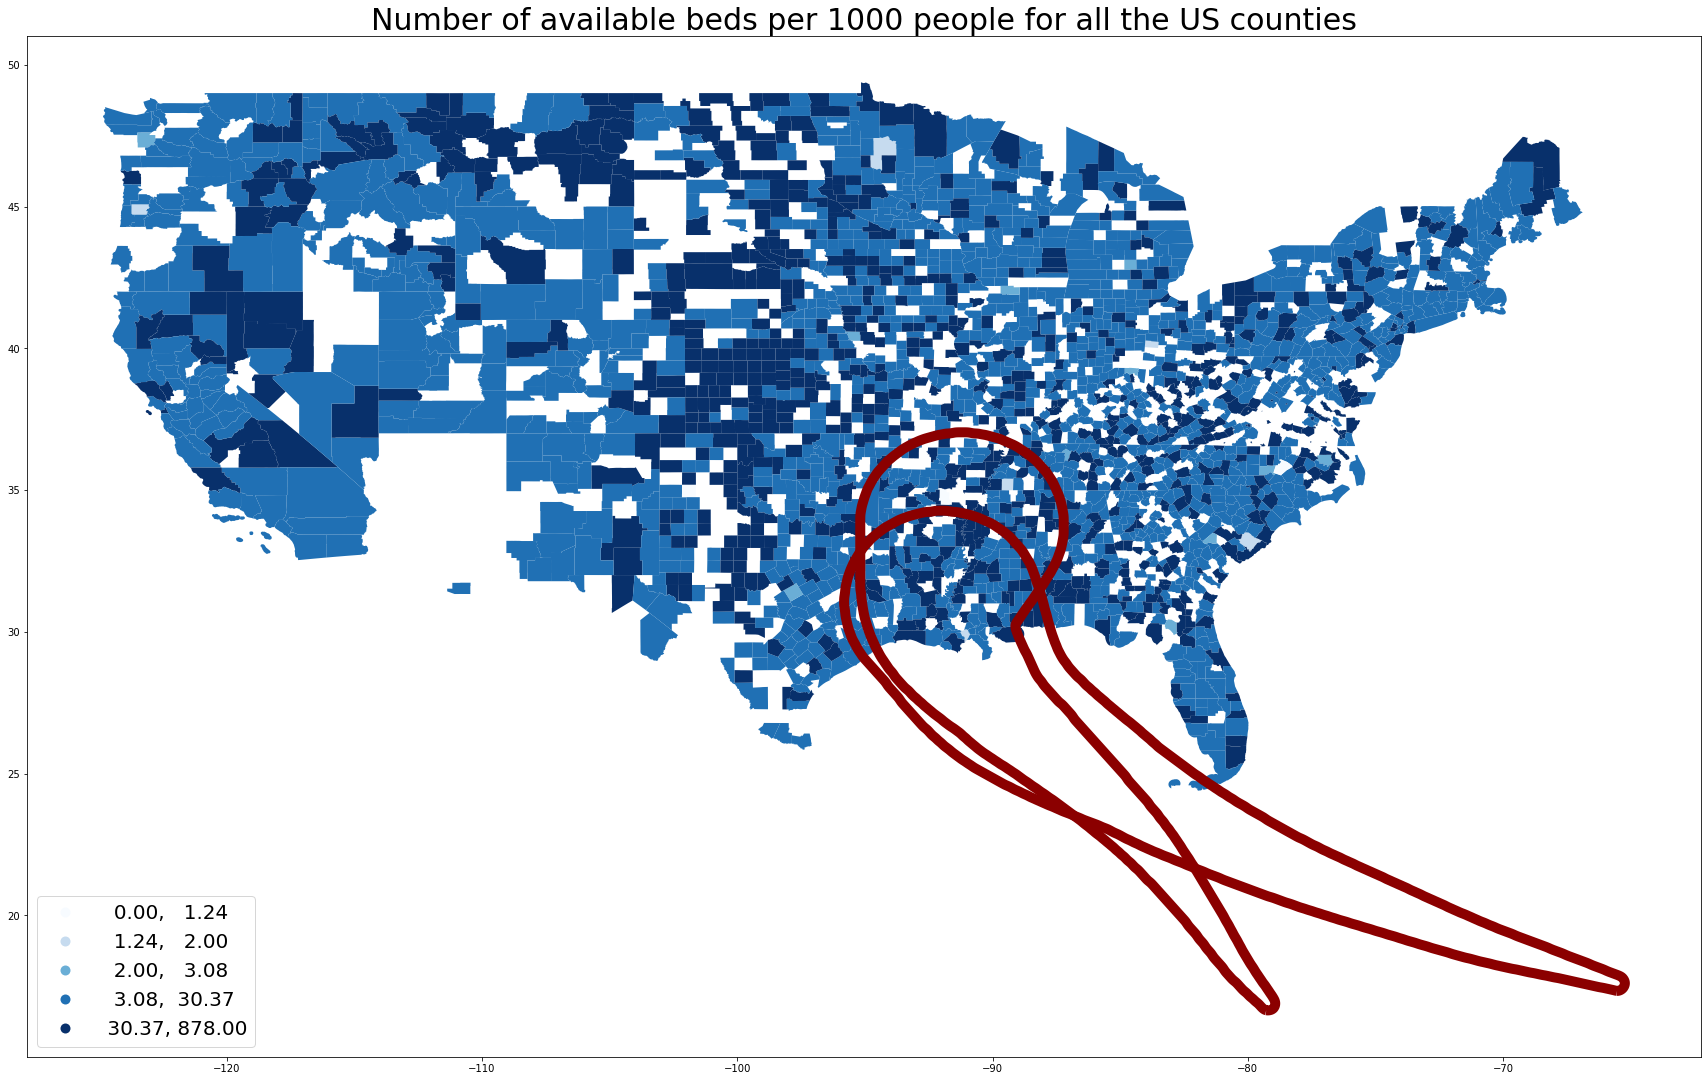

In [63]:
fig, ax = plt.subplots(1, figsize=(30,20))
base = hosp_census_countySHP_join.plot(ax=ax, column = 'Bed_per_1000', cmap = 'Blues', scheme = "UserDefined", 
                                       classification_kwds=dict(bins=[1.24,2,3.08,30.37]), 
                                       legend = True, legend_kwds={'loc': 'lower left', 'fontsize': 20})

# plotting the hurricane position on top with red color to stand out:
ida.boundary.plot(ax=base, color = 'darkred', linewidth=10)
laura.boundary.plot(ax=base, color = 'darkred', linewidth=10)
plt.title(label = "Number of available beds per 1000 people for all the US counties", fontsize = 30)

### Download income ranges for a middle class family for all the states

In [29]:
income_html = pd.read_html('https://www.considerable.com/money/economy/what-is-middle-class-in-every-state/')[0]
new_header = income_html.iloc[0] #grab the first row for the header
income_html = income_html[1:] #take the data less the header row
income_html.columns = new_header

In [30]:
import re
lowerlimit = []
upperlimit = []
for i in range(len(income_html)):
    
    # extract lower income limit
    test_stringLower = income_html.iloc[i]['Single']
    lower = test_stringLower.split()[0]
    temp = re.findall(r'\d+', lower)
    res = ''.join(temp)
    lowerlimit.append(int(res))
        
    # extract upper income limit
    test_stringUpper = income_html.iloc[i]['Family of four']
    upper = test_stringUpper.split()[2]
    temp = re.findall(r'\d+', upper)
    res = ''.join(temp)
    upperlimit.append(int(res))

# add new columns    
income_html['Lower_limit'] = lowerlimit
income_html['Upper_limit'] = upperlimit

# drop unnecessary columns

income_html = income_html.reset_index()
income_html = income_html.drop(columns = ['index','Single','Couple', 'Family of four'])
income_html.head()

,State,Lower_limit,Upper_limit
0,U.S. average,26093,156560
1,Alabama,22597,135581
2,Alaska,27502,165015
3,Arizona,25024,150141
4,Arkansas,22675,136051


### Segregate income data into 3 categories: low, middle, high

This is performed to understand whether the hurricane has affected low or high income areas.

In [31]:
inc_cat = []
for i in range(len(hosp_census_countySHP_join)):
    
    # extract state and income
    sn = hosp_census_countySHP_join.iloc[i]['stateName']
    inc = hosp_census_countySHP_join.iloc[i]['Income']
    
    # find the index of the above state in the income dataframe and extract lower and upper income limits 
    req_ind = income_html.index[income_html['State'] == sn][0]
    lower = income_html.iloc[req_ind]['Lower_limit']
    upper = income_html.iloc[req_ind]['Upper_limit']
    
    # compare the limits to the income corresponding to the county
    if inc < lower: inc_cat.append('low')
    elif (inc >= lower) & (inc < upper): inc_cat.append('middle')
    elif inc > upper: inc_cat.append('high')

# add the variable Income category
hosp_census_countySHP_join['Income_category'] = inc_cat

hosp_census_countySHP_join.head()

,geometry,Income,stateName,countyName,Bed_per_1000,PopDen,Income_category
0,"POLYGON ((-86.58826 32.36775, -86.58834 32.367...",21559.0,Alabama,Autauga County,14.0,93.60,low
1,"POLYGON ((-87.61542 31.04100, -87.61542 31.040...",84047.0,Alabama,Baldwin County,16.0,137.30,middle
2,"POLYGON ((-85.41585 31.68164, -85.41619 31.677...",9322.0,Alabama,Barbour County,27.0,28.28,low
3,"POLYGON ((-86.87657 33.01891, -86.87657 33.018...",7259.0,Alabama,Bibb County,14.0,35.94,low
4,"POLYGON ((-86.56421 33.80194, -86.56556 33.801...",21205.0,Alabama,Blount County,6.0,89.56,low


### Plotting "Income category" with hurricane tracks

Text(0.5, 1.0, 'Income Category for all the US counties')

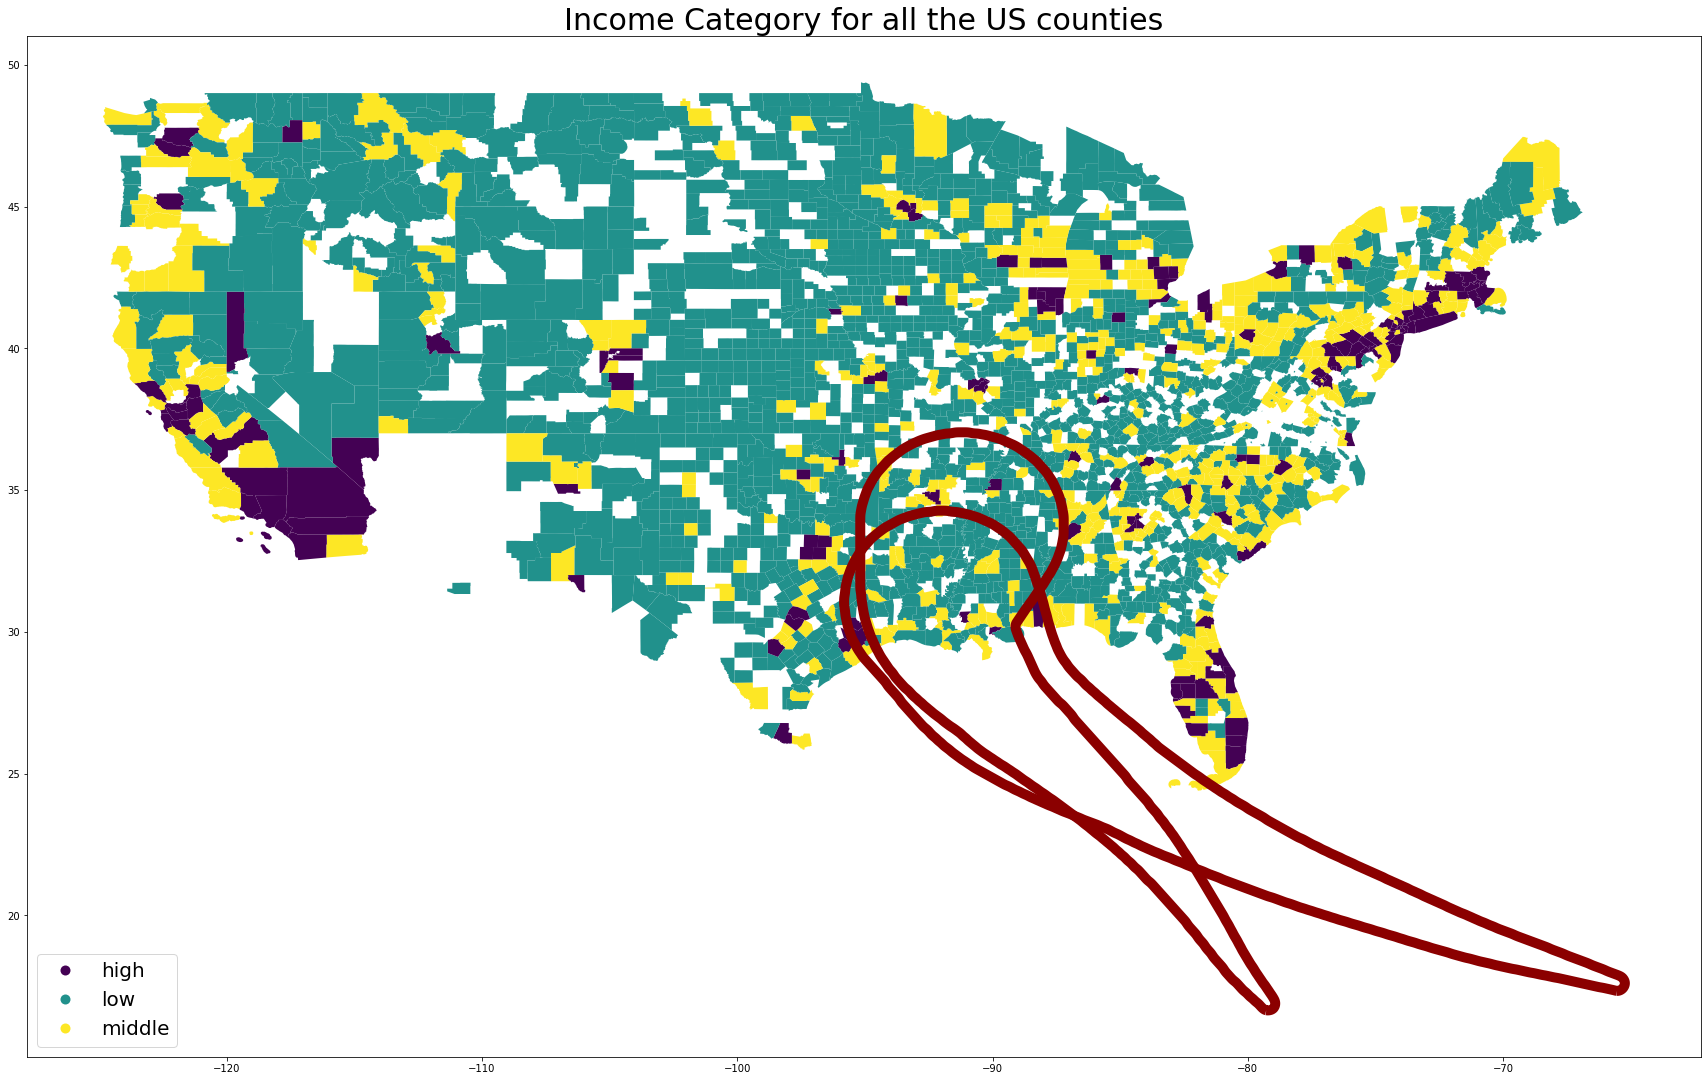

In [64]:
fig, ax = plt.subplots(1, figsize=(30,20))
base = hosp_census_countySHP_join.plot(ax=ax, column = 'Income_category', cmap = 'viridis', legend = True, 
                                       legend_kwds={'loc': 'lower left', 'fontsize': 20})

# plotting the hurricane position on top with red color to stand out:
ida.boundary.plot(ax=base, color = 'darkred', linewidth=10)
laura.boundary.plot(ax=base, color = 'darkred', linewidth=10)
plt.title(label = "Income Category for all the US counties", fontsize = 30)

### Find affected counties for Hurricane Ida

In [33]:
#Merge the hospital data and hurricane track using spatial join (Intersection) to find the affected counties.
Hurr_intersect_ida = hosp_census_countySHP_join.overlay(ida, how='intersection')

In [34]:
Hurr_intersect_ida.head()

,Income,stateName,countyName,Bed_per_1000,PopDen,Income_category,STORMNAME,geometry
0,7259.0,Alabama,Bibb County,14.0,35.94,low,Nine,"POLYGON ((-87.36581 32.87469, -87.37455 32.874..."
1,5330.0,Alabama,Choctaw County,18.0,13.96,low,Nine,"POLYGON ((-88.15991 31.85083, -88.16109 31.847..."
2,9323.0,Alabama,Clarke County,43.0,19.27,low,Nine,"POLYGON ((-88.07565 31.59845, -88.07892 31.601..."
3,21797.0,Alabama,Colbert County,59.0,92.68,low,Nine,"POLYGON ((-87.76480 34.73485, -87.76226 34.735..."
4,6805.0,Alabama,Fayette County,33.0,26.14,low,Nine,"POLYGON ((-87.67362 33.91511, -87.67200 33.915..."


In [35]:
affected_states = Hurr_intersect_ida.stateName.unique()
print("The states affected by Hurricane Ida are:", affected_states)

The states affected by Hurricane Ida are: ['Alabama' 'Arkansas' 'Kentucky' 'Louisiana' 'Mississippi' 'Missouri'
 'Oklahoma' 'Tennessee' 'Texas']


### Plotting Population Density, Beds availability per 1000 people and Income category for affected counties

In [36]:
ida_affected_counties = Hurr_intersect_ida['geometry'].bounds
ida_bounds = ida['geometry'].bounds
frames = [ida_affected_counties, ida_bounds]
result = pd.concat(frames)

In [37]:
min_x = result['minx'].min()
min_y = result['miny'].min()

max_x = result['maxx'].max()
max_y = result['maxy'].max()

Text(0.5, 1.0, 'Population Density of Counties Affected by Hurricane Ida')

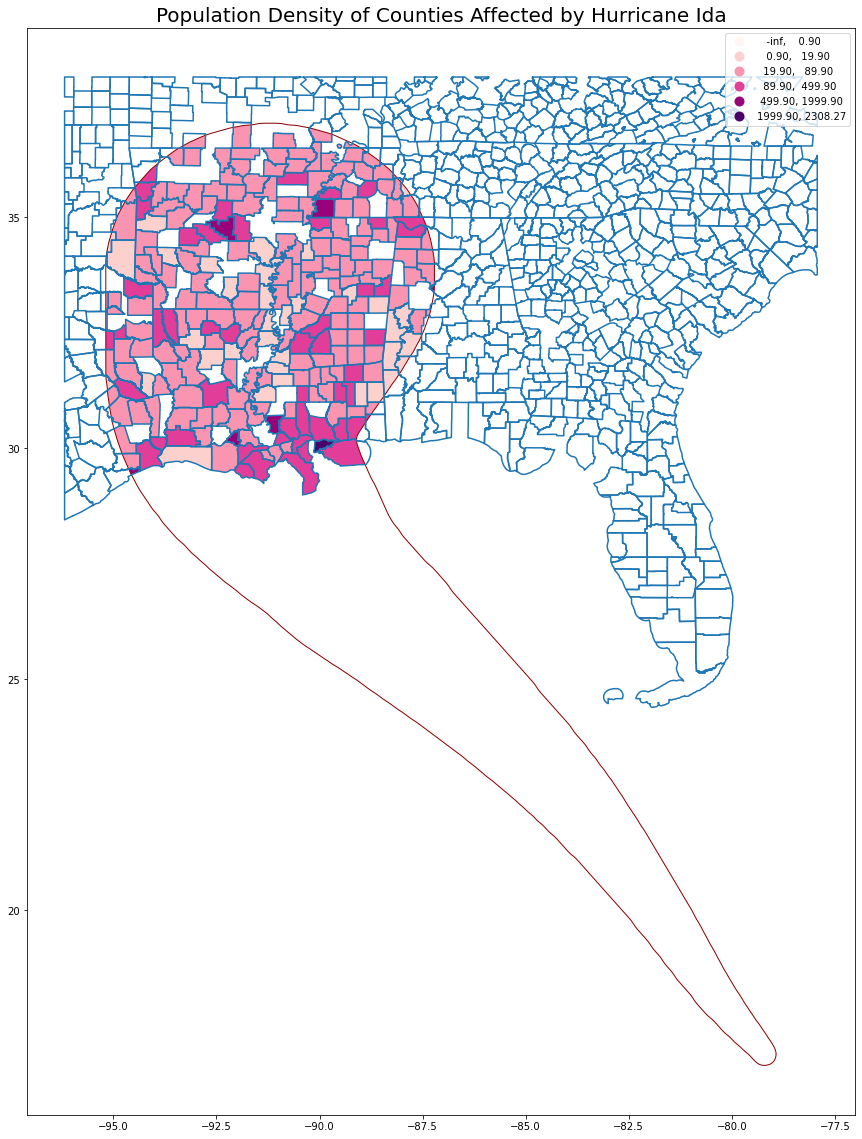

In [67]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon


#Plotting the population density of affected counties
# Create a custom polygon
polygon = Polygon([(min_x-1, min_y-1), (min_x-1, max_y+1), (max_x+1, max_y+1), (max_x+1, min_y-1), (min_x-1, min_y-1)])

ida_clipped = hosp_census_countySHP_join.clip(polygon)


fig, ax = plt.subplots(1, figsize=(30,20))
max_popDen = Hurr_intersect_ida['PopDen'].max()

base = ida_clipped.boundary.plot(ax=ax)

Hurr_intersect_ida.plot(ax=base, column = 'PopDen', cmap = 'RdPu', scheme = "UserDefined", classification_kwds=dict(bins=[0.9,19.9,89.9,499.9,1999.9,max_popDen]),legend = True)

# plotting the hurricane position on top with red color to stand out:
ida.plot(ax=base, edgecolor='darkred', color = 'none')
plt.title(label = "Population Density of Counties Affected by Hurricane Ida", fontsize = 20)

Text(0.5, 1.0, 'Number of Available Beds per 1000 People for the Counties Affected by Hurricane Ida')

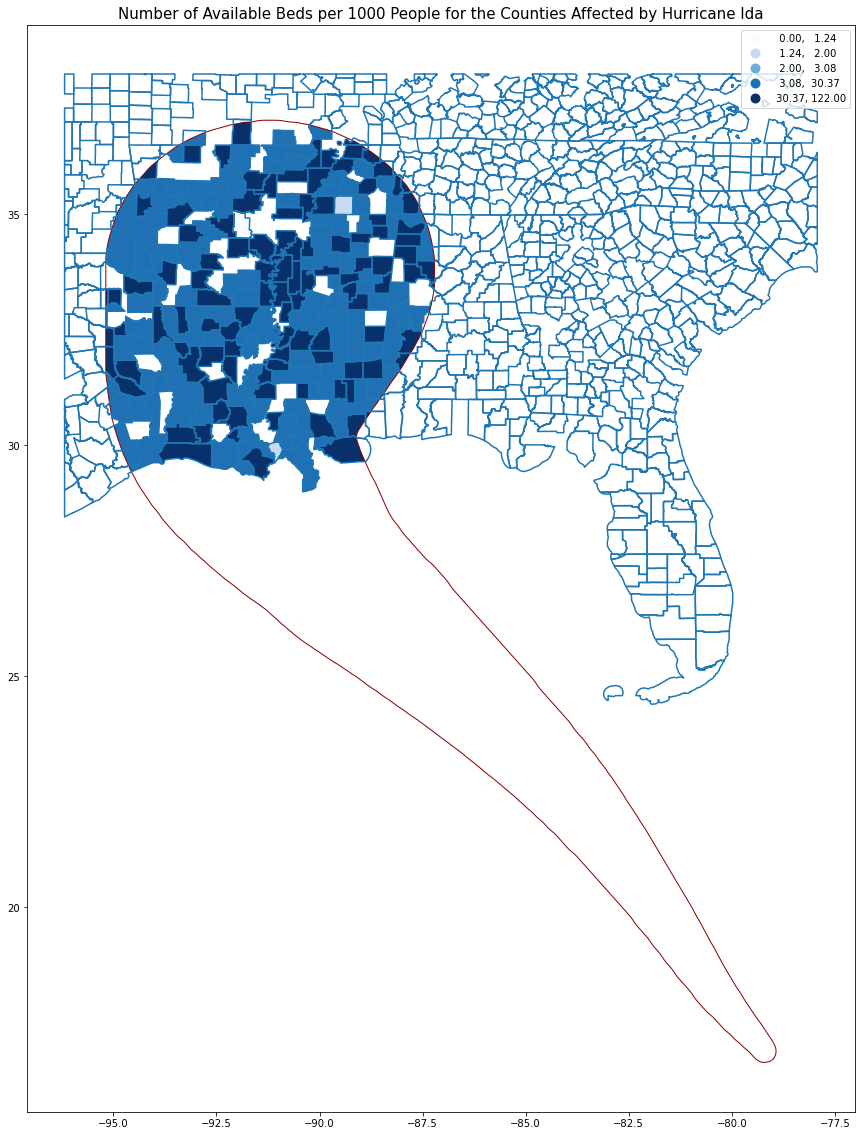

In [69]:
#Plotting the Bed_per_1000 of affected counties

fig, ax = plt.subplots(1, figsize=(30,20))
max_bedper1k = Hurr_intersect_ida['Bed_per_1000'].max()

base = ida_clipped.boundary.plot(ax=ax)

Hurr_intersect_ida.plot(ax=base, column = 'Bed_per_1000', cmap = 'Blues', scheme = "UserDefined", classification_kwds=dict(bins=[1.24,2,3.08,30.37,max_bedper1k]), legend = True)

# plotting the hurricane position on top with red color to stand out:
ida.plot(ax=base, edgecolor='darkred', color = 'none')
plt.title(label = "Number of Available Beds per 1000 People for the Counties Affected by Hurricane Ida", fontsize = 15)

Text(0.5, 1.0, 'Income Category of Counties Affected by Hurricane Ida')

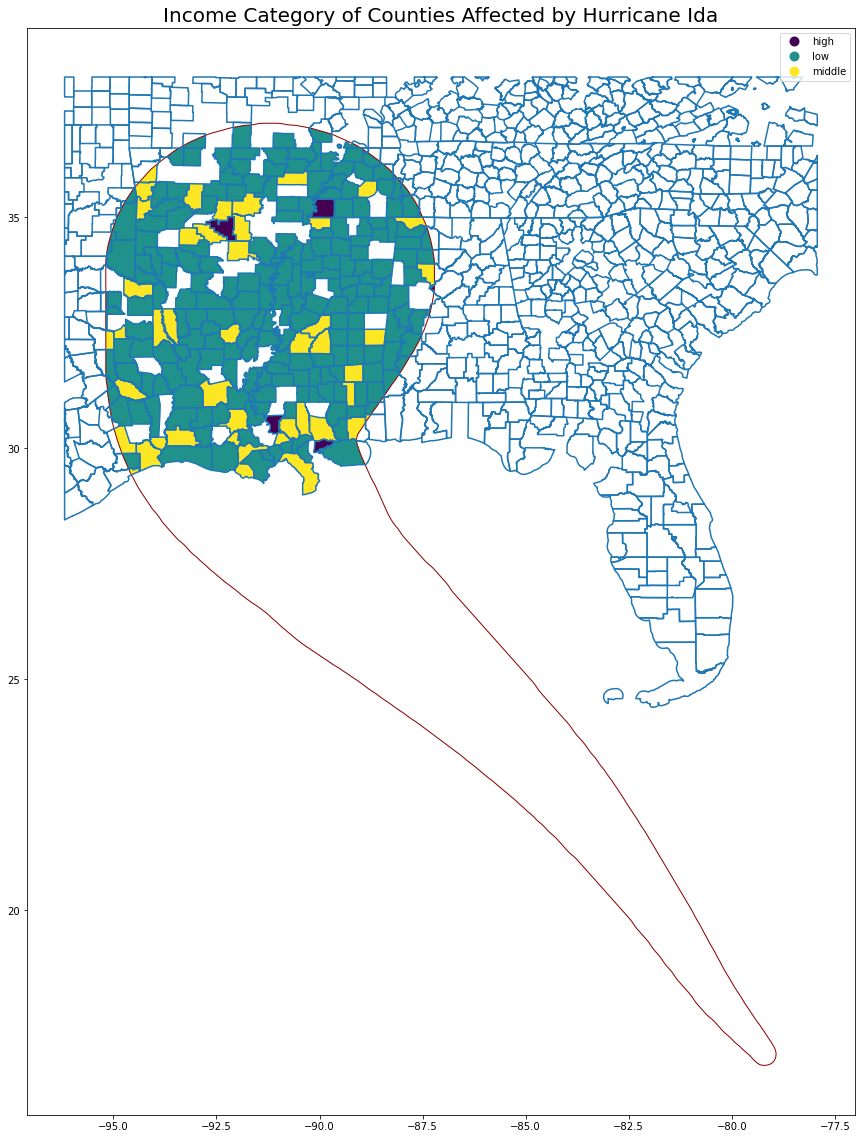

In [70]:
#Plotting the income category of affected counties

fig, ax = plt.subplots(1, figsize=(30,20))

base = ida_clipped.boundary.plot(ax=ax)

Hurr_intersect_ida.plot(ax=base, column = 'Income_category', cmap = 'viridis', legend = True)

# plotting the hurricane position on top with red color to stand out:
ida.plot(ax=base, edgecolor='darkred', color = 'none')
plt.title(label = "Income Category of Counties Affected by Hurricane Ida", fontsize = 20)

## Step 8: Understanding the distribution of key variables

### Population Density

In [41]:
Top5_PopDen = Hurr_intersect_ida.nlargest(5, ['PopDen'])
Top5_PopDen[['stateName', 'countyName', 'PopDen']]

,stateName,countyName,PopDen
104,Louisiana,Orleans Parish,2308.27
230,Tennessee,Shelby County,1231.49
89,Louisiana,East Baton Rouge Parish,972.91
96,Louisiana,Lafayette Parish,906.51
241,Texas,Galveston County,890.10


***From the above table, we can find out which counties have the highest population density and focus on relocation-based relief efforts for those counties. But the data might have some outliers. To check that, we plotted a boxplot.***

<AxesSubplot:>

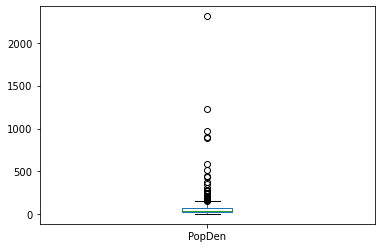

In [42]:
Hurr_intersect_ida.boxplot(column =['PopDen'], grid = False)

***As we can see, there are a lot of outliers. So to remove them, we used a method called IQR to identify them.***

Interquartile Range (IQR) - A commonly used rule says that a data point is an 
outlier if it is more than 1.5*IQR above the third quartile or below the first quartile. IQR is 
calculated as : Q3-Q1. Low outliers are below Q1 − 1.5 * IQR and High outliers are above Q3 + 
1.5 * IQR where Q1 is the first quartile and Q3 is the third quartile.


In [43]:
Q1 = Hurr_intersect_ida['PopDen'].quantile(0.25)
Q3 = Hurr_intersect_ida['PopDen'].quantile(0.75)
IQR = Q3 - Q1
filter = (Hurr_intersect_ida['PopDen'] >= Q1 - 1.5 * IQR) & (Hurr_intersect_ida['PopDen'] <= Q3 + 1.5 *IQR)
print("Number of outliers:",len(Hurr_intersect_ida) - len(Hurr_intersect_ida.loc[filter]))
print("Number of datapoints in the original dataset:", len(Hurr_intersect_ida))

Number of outliers: 31
Number of datapoints in the original dataset: 260


array([[<AxesSubplot:title={'center':'PopDen'}>]], dtype=object)

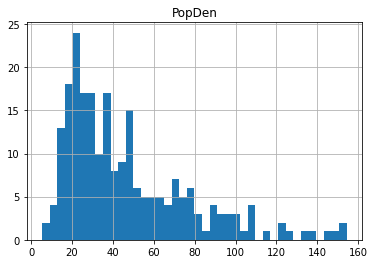

In [44]:
Hurr_intersect_ida.loc[filter].hist(column='PopDen', bins = 40)

***From the histogram, we can see that the density of most of the counties is below 100.***

### Bed availability per 1000 people

In [45]:
lowest_bed_av = Hurr_intersect_ida.nsmallest(5, ['Bed_per_1000'])
lowest_bed_av[['stateName', 'countyName', 'Bed_per_1000']]

,stateName,countyName,Bed_per_1000
53,Arkansas,Lonoke County,0.0
77,Louisiana,Assumption Parish,2.0
218,Tennessee,Fayette County,2.0
100,Louisiana,Livingston Parish,4.0
249,Texas,Orange County,4.0


***From the above table, we can find out which counties have the lowest bed availability per 1000 people and focus on medical relief efforts for those counties. But the data might have some outliers as we can see above for Lonoke county which has 0 beds per 1000. To check that, we plotted a boxplot. After removing the outliers with the same method as above, we plotted a histogram to understand the distribution correctly.***

<AxesSubplot:>

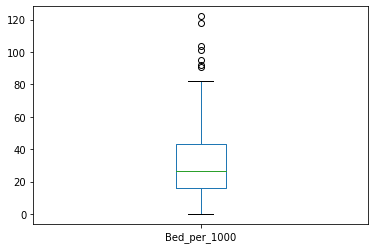

In [46]:
Hurr_intersect_ida.boxplot(column =['Bed_per_1000'], grid = False)

In [47]:
Q1 = Hurr_intersect_ida['Bed_per_1000'].quantile(0.25)
Q3 = Hurr_intersect_ida['Bed_per_1000'].quantile(0.75)
IQR = Q3 - Q1
filter = (Hurr_intersect_ida['Bed_per_1000'] >= Q1 - 1.5 * IQR) & (Hurr_intersect_ida['Bed_per_1000'] <= Q3 + 1.5 *IQR)
print("Number of outliers:",len(Hurr_intersect_ida) - len(Hurr_intersect_ida.loc[filter]))
print("Number of datapoints in the original dataset:", len(Hurr_intersect_ida))

Number of outliers: 7
Number of datapoints in the original dataset: 260


array([[<AxesSubplot:title={'center':'Bed_per_1000'}>]], dtype=object)

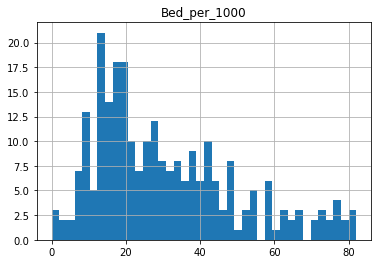

In [48]:
Hurr_intersect_ida.loc[filter].hist(column='Bed_per_1000', bins = 40)

### Income category

<AxesSubplot:>

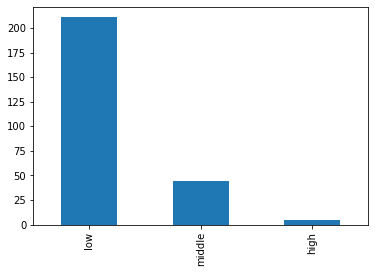

In [49]:
Hurr_intersect_ida['Income_category'].value_counts().plot(kind='bar')

***We can see that most of the affected counties come under low income category. And from the map plotted before, we can know which are those counties and focus on appropriate relief efforts for them.***

## Conclusion

The analysis helped us to determine the counties affected due to Ida. The distributions shows that most of the affected counties have a population density range of 20-60 , 20-40 beds per 1000 individuals and most of them are low incomed counties. Based on these statistics, the relief measures can be executed to allocate more beds in less available aread and evacuation plans for counties with high population density.

Code reusability – Code has been designed in a way to replace the hurricane track data for any future hurricanes and analyze its impact on the US counties. 